<a href="https://colab.research.google.com/github/inffe/ml-unn/blob/main/1lr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Решение задачи классификации

**0. Описание задачи**

Датасет включает в себя 42 тысячи записей о рассматриваемых банком теоретических вкладчиков. Как говорят финансисты, это один из главных источников дохода банков. Телефонные маркетинговые кампании являются одним из наиболее эффективных способов привлечь людей (для рассматриваемого времени 2008-2010 год), однако это требует больших затрат на колл-центры, который и будут производить обзвон. Поэтому требуется по имеющимся данным выбрать наиболее вероятных вкладчиков, сэкономив при этом на звонках и людях. 

Необходимо по имеющимся признакам понять, будет ли человек вкладывать деньги в банк или нет.

In [3]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения

**0.5 Загрузка данных**

In [4]:
url = "https://raw.githubusercontent.com/inffe/ml-unn/main/Banking_dataset.csv"
data_raw = pd.read_csv(url)

Размерность и вид датасета:

In [5]:
data_raw.shape

(45211, 17)

In [6]:
data_raw.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Изначальные параметры:

- age (numeric)
- job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")

- marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

- education (categorical: "unknown","secondary","primary","tertiary")

- default: has credit in default? (binary: "yes","no")
- balance: average yearly balance, in euros (numeric)

- housing: has housing loan? (binary: "yes","no")

- loan: has personal loan? (binary: "yes","no")

- contact: contact communication type (categorical: "unknown","telephone","cellular")

- day: last contact day of the month (numeric)

- month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")

- duration: last contact duration, in seconds (numeric)

- campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

- pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

- previous: number of contacts performed before this campaign and for this client (numeric)

- poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

- y - has the client subscribed a term deposit? (binary: "yes","no")

Параметы 9-12, которые отображают лишь системную информацию о контактах с клиентом, можно убрать из-за отсутствия или слишком незначительной роли в итоговом выборе брать кредит или нет. 

Нельзя говорить об отсутствии эффекта маркетинга, поэтому оставим параметр 13, который будет отображать слышал ли человек об этой рекламной кампании. Остальные параметры также можно упразднить.

Итоговые параметры:

- Age: (numeric)

- Job: type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services")

- Marital: marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

- Education: (categorical: "unknown","secondary","primary","tertiary")

- Default: credit in default? (binary: "yes","no")

- Balance: average yearly balance, in euros (numeric)

- Housing: has housing loan? (binary: "yes","no")

- Loan: has personal loan? (binary: "yes","no")

- Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

- Deposit - has the client subscribed a term deposit? (binary: "yes","no")

In [7]:
del data_raw['contact']
del data_raw['day']
del data_raw['month']
del data_raw['duration']
del data_raw['pdays']
del data_raw['previous']
del data_raw['poutcome']

Проверим количество столбцов

In [8]:
data_raw.shape

(45211, 10)

Переименуем столбец Y на deposit

In [9]:
data_raw.rename(columns = {'y':'deposit'}, inplace = True)

Сверим все изменения в датасете

In [10]:
data_raw.head()

,age,job,marital,education,default,balance,housing,loan,campaign,deposit
0,58,management,married,tertiary,no,2143,yes,no,1,no
1,44,technician,single,secondary,no,29,yes,no,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,1,no
4,33,unknown,single,unknown,no,1,no,no,1,no


**1. Чтение данные**

Поделим параметры на числовые и нечисловые

In [11]:
data_raw_numeric = data_raw.select_dtypes(include=[np.number])
numeric_cols = data_raw_numeric.values
data_raw_numeric

,age,balance,campaign
0,58,2143,1
1,44,29,1
2,33,2,1
3,47,1506,1
4,33,1,1
...,...,...,...
45206,51,825,3
45207,71,1729,2
45208,72,5715,5
45209,57,668,4


In [12]:
data_raw_no_numeric = data_raw.select_dtypes(exclude=[np.number])
non_numeric_cols = data_raw_no_numeric.values
data_raw_no_numeric

,job,marital,education,default,housing,loan,deposit
0,management,married,tertiary,no,yes,no,no
1,technician,single,secondary,no,yes,no,no
2,entrepreneur,married,secondary,no,yes,yes,no
3,blue-collar,married,unknown,no,yes,no,no
4,unknown,single,unknown,no,no,no,no
...,...,...,...,...,...,...,...
45206,technician,married,tertiary,no,no,no,yes
45207,retired,divorced,primary,no,no,no,yes
45208,retired,married,secondary,no,no,no,yes
45209,blue-collar,married,secondary,no,no,no,no


**2. Найдем основные параметры**

Найдем основные параметры числовых параметров

In [13]:
data_raw_numeric.describe()

,age,balance,campaign
count,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,2.763841
std,10.618762,3044.765829,3.098021
min,18.000000,-8019.000000,1.000000
25%,33.000000,72.000000,1.000000
50%,39.000000,448.000000,2.000000
75%,48.000000,1428.000000,3.000000
max,95.000000,102127.000000,63.000000


Посмотрим квантили квантили разных уровней для переменной баланс

In [14]:
data_raw_numeric['balance'].quantile([0.005,.01,.05,.1,.5,.9,.95,.99,.995])

0.005     -867.95
0.010     -627.00
0.050     -172.00
0.100        0.00
0.500      448.00
0.900     3574.00
0.950     5768.00
0.990    13164.90
0.995    18014.35
Name: balance, dtype: float64

Отбросим самые крайние значения, невходящие в квантиль 0.005 и 0.995 соответственно

In [15]:
rows_to_drop = data_raw[
    (data_raw['balance'] < data_raw['balance'].quantile(0.005)) | (data_raw['balance'] > data_raw['balance'].quantile(0.995)) | 
    (data_raw['campaign']  < data_raw['campaign' ].quantile(0.005)) | (data_raw['campaign']  > data_raw['campaign'].quantile(0.995))
    ].index
data_raw = data_raw.drop(rows_to_drop)
data_raw.shape

(44549, 10)

Посмотрим на основные параметры после оптимизации значений

In [16]:
data_raw.describe()

,age,balance,campaign
count,44549.000000,44549.000000,44549.000000
mean,40.910256,1239.726885,2.642618
std,10.616040,2162.245786,2.511888
min,18.000000,-867.000000,1.000000
25%,33.000000,76.000000,1.000000
50%,39.000000,451.000000,2.000000
75%,48.000000,1411.000000,3.000000
max,95.000000,17983.000000,21.000000


Визуализируем имеющиеся параметры

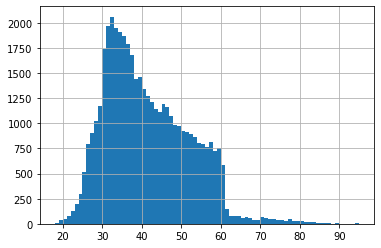

In [17]:
data_raw['age'].hist(bins=77)

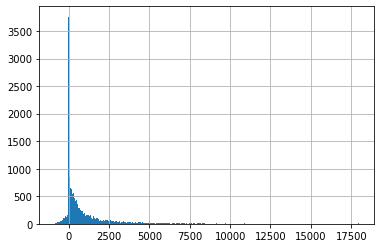

In [18]:
data_raw['balance'].hist(bins=1000)

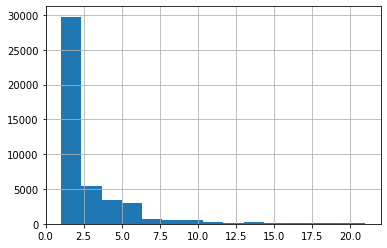

In [19]:
data_raw['campaign'].hist(bins=15)

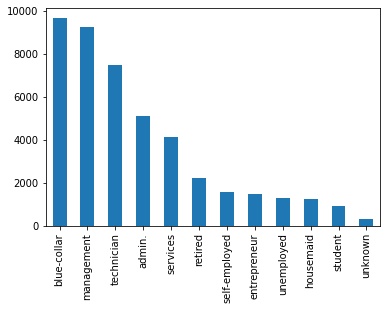

In [20]:
data_raw['job'].value_counts().plot(kind='bar')

In [21]:
data_raw_check_job = data_raw['job']

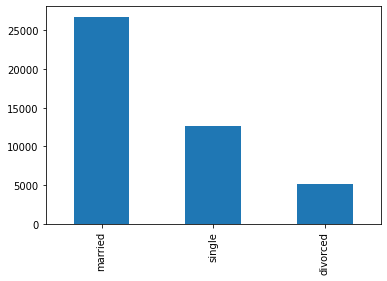

In [22]:
data_raw['marital'].value_counts().plot(kind='bar')

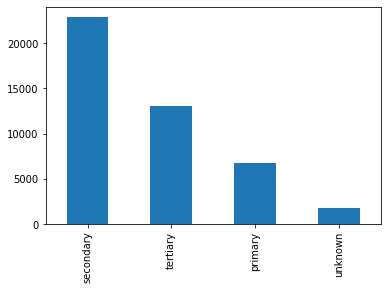

In [23]:
data_raw['education'].value_counts().plot(kind='bar')

In [24]:
data_raw_check_education = data_raw['education']

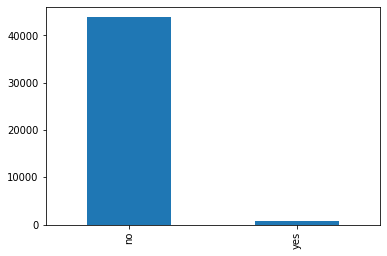

In [25]:
data_raw['default'].value_counts().plot(kind='bar')

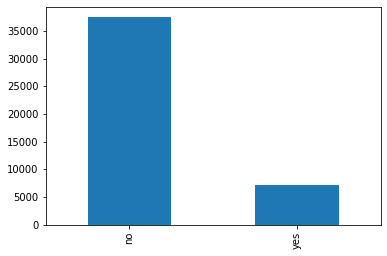

In [26]:
data_raw['loan'].value_counts().plot(kind='bar')

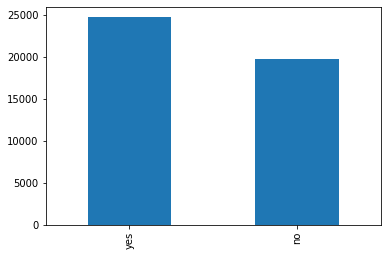

In [27]:
data_raw['housing'].value_counts().plot(kind='bar')

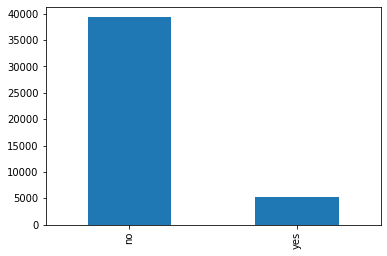

In [28]:
data_raw['deposit'].value_counts().plot(kind='bar')

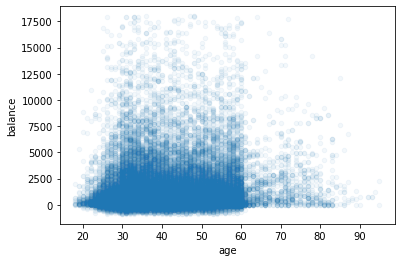

In [29]:
data_raw.plot(kind = 'scatter', x = 'age', y = 'balance', alpha=0.05)

Построим матрицу корреляции с нумерованными значениями

In [30]:
corr_matrix = data_raw.corr()
corr_matrix

,age,balance,campaign
age,1.000000,0.098707,0.016726
balance,0.098707,1.000000,-0.017119
campaign,0.016726,-0.017119,1.000000


Можно сделать вывод, что от возраста сильно зависит баланс счета, а вот с количеством звонков явной корреляции не прослеживается

**3. Обработка пустых значений**

Как известно, два нечисловых параметра имеют пропущенные значения и обозначаются как `Unknown`. 

Заменим их на рандомную одну из известных величин для параметра `Job` и `Education`.

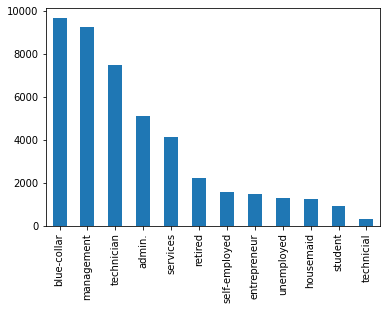

In [31]:
fix_job = ['blue-collar', 'management', 'technicial', 'admin', 'services', 'retired', 'self-employed', 'enterpreneur', 'unemployed', 'housemaid', 'student']
data_raw.loc[(data_raw.job == 'unknown'), 'job'] = np.random.choice(fix_job)
data_raw['job'].value_counts().plot(kind='bar')

И для параметра `Education`:

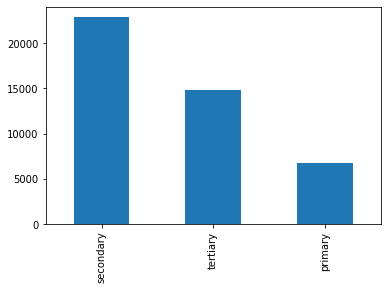

In [32]:
fix_education = ['primary', 'tertiary', 'secondary']
data_raw.loc[(data_raw.education == 'unknown'), 'education'] = np.random.choice(fix_education)
data_raw['education'].value_counts().plot(kind='bar')

In [33]:
data_raw['education'].value_counts()

secondary    22916
tertiary     14851
primary       6782
Name: education, dtype: int64

**3. Обработать категориальные признаки**

Признаки `Job`, `Marital`, `Education`, `Housing`, `Default`, `Loan`, `Deposit` - номинальные, поэтому им необходимо изменить тип

In [34]:
data_raw['job']

0          management
1          technician
2        entrepreneur
3         blue-collar
4          technicial
             ...     
45206      technician
45207         retired
45208         retired
45209     blue-collar
45210    entrepreneur
Name: job, Length: 44549, dtype: object

In [35]:
data_raw['job'] = data_raw['job'].astype('category')
data_raw['marital'] = data_raw['marital'].astype('category')
data_raw['education'] = data_raw['education'].astype('category')

Бинарные признаки заменим на числовые

In [36]:
data_raw['housing'] = pd.factorize(data_raw['housing'])[0]
data_raw['default'] = pd.factorize(data_raw['default'])[0]
data_raw['loan'] = pd.factorize(data_raw['loan'])[0]
data_raw['deposit'] = pd.factorize(data_raw['deposit'])[0]

In [37]:
data_raw.head()


,age,job,marital,education,default,balance,housing,loan,campaign,deposit
0,58,management,married,tertiary,0,2143,0,0,1,0
1,44,technician,single,secondary,0,29,0,0,1,0
2,33,entrepreneur,married,secondary,0,2,0,1,1,0
3,47,blue-collar,married,tertiary,0,1506,0,0,1,0
4,33,technicial,single,tertiary,0,1,1,0,1,0


К категориальным (небинарным) признакам `Job`, `Marital`, `Education` применим метод бинаризации (one-hot encoding), который заключается в следующем.

Каждый из признаков имеет по несколько возможных значений. 

Вместо признака `Education` будем использовать 3 новых признаков (dummy-признаков, dummy - фиктивный), которые так и назовем `Primary`, `Secondary` и `Tertiary`. 

При этом если признак 'Education' принимает значение `Primary`, то признак 'Primary' равен 1, а все остальные 0;
если признак 'Education' принимает значение `Secondary`, то признак `Secondary` равен 1, а все остальные 0
и т.д.
Такую бинаризацию можно выполнить с помощью функции get_dummies:

In [38]:
Job_dummies = pd.get_dummies(data_raw['job'])
Marital_dummies = pd.get_dummies(data_raw['marital'])
Education_dummies = pd.get_dummies(data_raw['education'])

In [39]:
Job_dummies.head()

,admin.,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technicial,technician,unemployed
0,0,0,0,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0


In [40]:
Marital_dummies.head()

,divorced,married,single
0,0,1,0
1,0,0,1
2,0,1,0
3,0,1,0
4,0,0,1


In [41]:
Education_dummies.head()

,primary,secondary,tertiary
0,0,0,1
1,0,1,0
2,0,1,0
3,0,0,1
4,0,0,1


Добавим полученные столбцы в таблицу и удалим образующий их параметр

In [42]:
data_raw = pd.concat((data_raw, Job_dummies), axis=1)
data_raw = pd.concat((data_raw, Marital_dummies), axis=1)
data_raw = pd.concat((data_raw, Education_dummies), axis=1)
data_raw = data_raw.drop(['job'], axis=1)
data_raw = data_raw.drop(['marital'], axis=1)
data_raw = data_raw.drop(['education'], axis=1)

In [43]:
data_raw.head()

,age,default,balance,housing,loan,campaign,deposit,admin.,blue-collar,entrepreneur,...,student,technicial,technician,unemployed,divorced,married,single,primary,secondary,tertiary
0,58,0,2143,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,44,0,29,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,1,0
2,33,0,2,0,1,1,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
3,47,0,1506,0,0,1,0,0,1,0,...,0,0,0,0,0,1,0,0,0,1
4,33,0,1,1,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [44]:
data_raw.describe()

,age,default,balance,housing,loan,campaign,deposit,admin.,blue-collar,entrepreneur,...,student,technicial,technician,unemployed,divorced,married,single,primary,secondary,tertiary
count,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,...,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000
mean,40.910256,0.016678,1239.726885,0.444926,0.159083,2.642618,0.117668,0.114638,0.216346,0.032571,...,0.020943,0.006375,0.167972,0.028957,0.115177,0.601091,0.283733,0.152237,0.514400,0.333363
std,10.616040,0.128064,2162.245786,0.496963,0.365758,2.511888,0.322218,0.318588,0.411758,0.177513,...,0.143196,0.079590,0.373846,0.167687,0.319238,0.489679,0.450814,0.359254,0.499798,0.471420
min,18.000000,0.000000,-867.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,33.000000,0.000000,76.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,39.000000,0.000000,451.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,48.000000,0.000000,1411.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,95.000000,1.000000,17983.000000,1.000000,1.000000,21.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**4. Нормализация данных**

Нормализация, или приведение к отрезку  [0,1]  - это линейное преобразование, приводящее все значения к заданному отрезку;

In [45]:
data_norm = (data_raw - data_raw.min(axis = 0))/(data_raw.max(axis = 0) - data_raw.min(axis = 0))

In [46]:
data_norm.describe()

,age,default,balance,housing,loan,campaign,deposit,admin.,blue-collar,entrepreneur,...,student,technicial,technician,unemployed,divorced,married,single,primary,secondary,tertiary
count,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,...,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000,44549.000000
mean,0.297536,0.016678,0.111763,0.444926,0.159083,0.082131,0.117668,0.114638,0.216346,0.032571,...,0.020943,0.006375,0.167972,0.028957,0.115177,0.601091,0.283733,0.152237,0.514400,0.333363
std,0.137871,0.128064,0.114708,0.496963,0.365758,0.125594,0.322218,0.318588,0.411758,0.177513,...,0.143196,0.079590,0.373846,0.167687,0.319238,0.489679,0.450814,0.359254,0.499798,0.471420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.194805,0.000000,0.050027,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.272727,0.000000,0.069920,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,0.389610,0.000000,0.120849,1.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**5. Классификация данных**

In [47]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split

В качестве обучающей выборки возьмем 80% данных, остальные 20% включим в тестовую.

In [50]:
X = data_norm.drop(["default"], 1)
y = data_norm["default"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17711)
y_train

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


17657    0.0
15522    0.0
9978     0.0
42972    0.0
21467    0.0
        ... 
40932    0.0
21719    0.0
24706    0.0
26255    0.0
5158     0.0
Name: default, Length: 35639, dtype: float64

Метод К ближайших соседей

In [51]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)
print("Accuracy score: train {}, test {}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
print("Mean-squared error: train {}, test {}".format(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


Accuracy score: train 0.9838659895058784, test 0.9819304152637486
Mean-squared error: train 0.01613401049412161, test 0.018069584736251403


Для параметра К = 5

In [53]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)
print("Accuracy score: train {}, test {}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
print("Mean-squared error: train {}, test {}".format(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


Accuracy score: train 0.9838659895058784, test 0.9819304152637486
Mean-squared error: train 0.01613401049412161, test 0.018069584736251403


Метод Random forest

In [54]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)
print("Accuracy score: train {}, test {}".format(accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)))
print("Mean-squared error: train {}, test {}".format(mean_squared_error(y_train, y_train_pred), mean_squared_error(y_test, y_test_pred)))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


Accuracy score: train 0.9995510536210331, test 0.9818181818181818
Mean-squared error: train 0.00044894637896686216, test 0.01818181818181818


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


**6. Вывод**

Метод к-ближайших соседей оказался эффективнее, но разница между ними незначительная